In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../'))
import SortedNoDupeBedOverlap as bdO
import annotate_sc_atac


In [2]:
mat = mmread('filtered_peak_bc_matrix/matrix.mtx')

In [3]:
mat = mat.toarray()

In [4]:
id2bc = pd.read_csv('filtered_peak_bc_matrix/barcodes.tsv', header = None)[0].values
id2peak = bdO.BedScan('filtered_peak_bc_matrix/peaks.bed')

In [7]:
df_peak = pd.read_csv('filtered_peak_bc_matrix/peaks.bed', header = None, sep = '\t')

In [6]:
len(id2peak)

84626

In [8]:
data_obj = sc.AnnData(mat.T, 
          obs = pd.DataFrame([], index = id2bc),
          var = df_peak,
          )

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.pp.normalize_total(data_obj)
sc.pp.pca(data_obj, n_comps=50)
sc.pp.neighbors(data_obj)
sc.tl.umap(data_obj)

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 0 as categorical


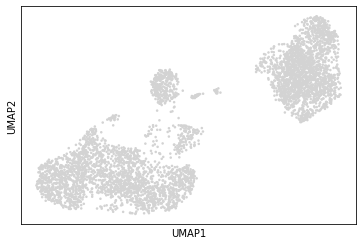

In [10]:
sc.pl.umap(data_obj)

In [11]:
ref_subtype_peaks, ref_bk_peak = annotate_sc_atac.read_reference_data('../../data/GSE129785/', verbose = False)

In [12]:
intersect = bdO.BedOverlap(id2peak, ref_bk_peak, 50)

set2_ref = []
for i, (ct, peaks) in enumerate(ref_subtype_peaks):
    peaks_intersect = bdO.BedOverlap(id2peak, peaks, 50)
    ref_subtype_peaks[i] = (ct, peaks_intersect)

In [13]:
tmp = set(['Basophil',
 'Central memory CD8 T',
 'Effector memory CD8 T',
 'Mature NK1',
 'Memory B',
 'Memory CD4 T',
 'Monocyte 1',
 'Naive B',
 'cDC',
 'pDC'])
ref_subtype_peaks = [item for item in ref_subtype_peaks if item[0] in tmp]

In [14]:
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Basophil 531
Central memory CD8 T 3155
Effector memory CD8 T 748
Mature NK1 2677
Memory B 1620
Memory CD4 T 2617
Monocyte 1 5634
Naive B 1508
cDC 5508
pDC 2082


In [15]:
mat.shape, len(id2peak)

((84626, 4654), 84626)

In [16]:
scores = annotate_sc_atac.compute_enrichment_score(mat, intersect, id2peak, ref_subtype_peaks, num_cores = 1)

In [24]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = data_obj.obs.index
                       )

In [25]:
score_df.head()

,Basophil,Central memory CD8 T,Effector memory CD8 T,Mature NK1,Memory B,Memory CD4 T,Monocyte 1,Naive B,cDC,pDC
AAACGAAAGCGCAATG-1,1.307802,0.938188,1.175453,0.972444,1.018887,0.984330,0.949867,1.101850,0.977581,0.902041
AAACGAAAGGGTATCG-1,1.317649,0.950423,0.783645,1.049512,1.003150,0.926761,0.911433,1.035156,1.094080,1.254091
AAACGAAAGTAACATG-1,0.740619,1.172723,1.454616,1.162072,0.827736,1.162577,0.920452,0.871136,0.873724,1.093738
AAACGAAAGTTACACC-1,0.779236,1.011072,0.943304,1.024552,1.035846,1.079491,1.149245,1.312058,1.127693,1.233089
AAACGAACAGAGATGC-1,0.772903,1.301624,0.855404,1.234060,1.055266,1.245212,1.036919,1.007439,0.782246,0.687084


In [26]:
data_obj.obs = score_df

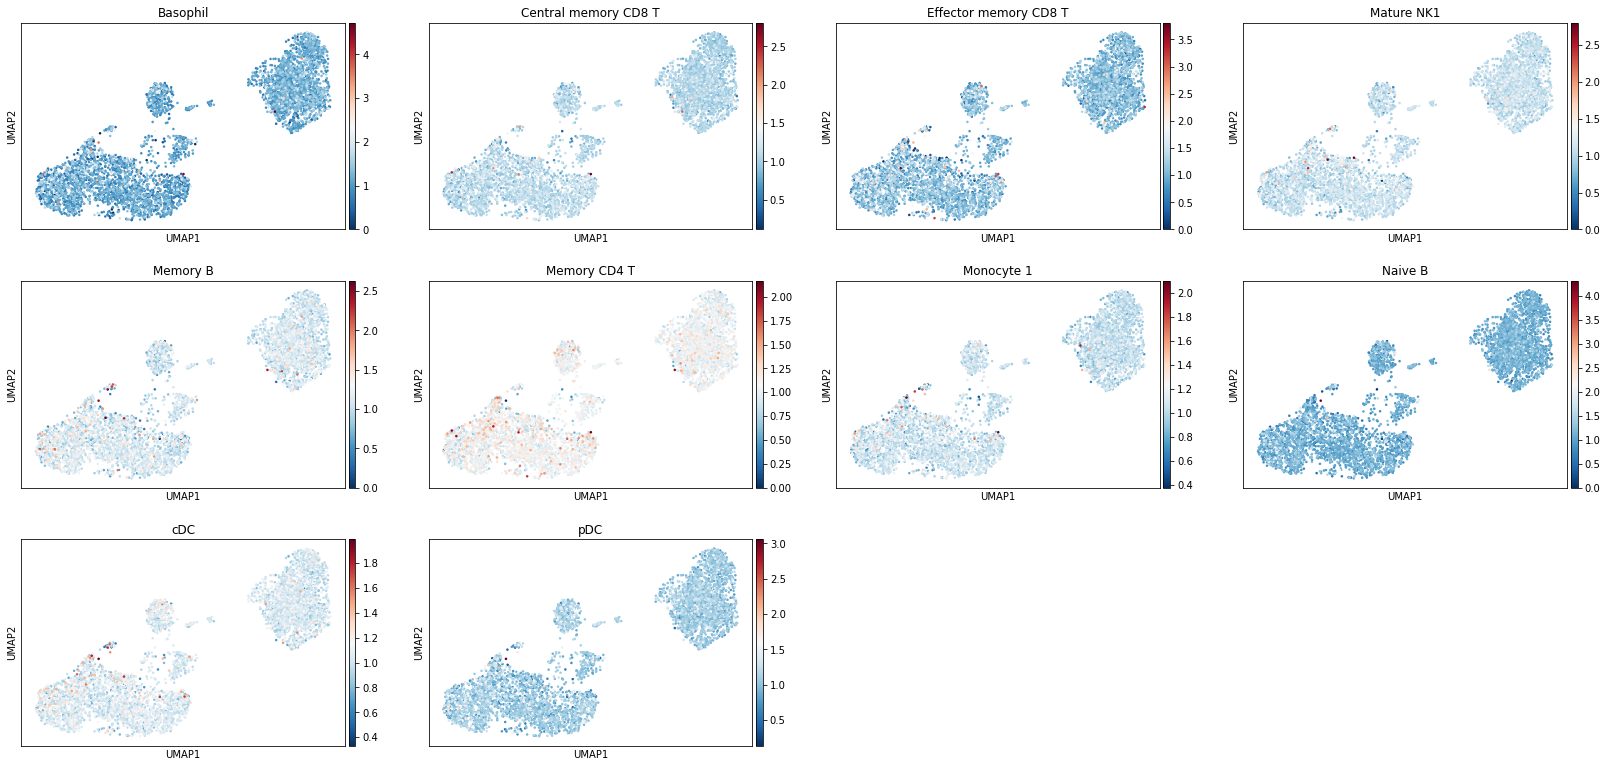

In [28]:
sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r')